In [70]:
# if actual departure time = 0, cancelled flight
# packages - datetime, calendar

In [71]:
import pandas as pd

In [72]:
import numpy as np

In [73]:
from collections import Counter

In [74]:
import geopandas as gpd

In [75]:
import folium

In [76]:
# packages for dealing with time
import datetime
from datetime import datetime as dt, date, timedelta
import calendar
import time

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

In [78]:
import seaborn as sns

In [79]:
#import sys
#sys.path.append('missingno')

In [80]:
#import missingno as msno

In [81]:
from ipywidgets import FloatProgress

In [82]:
from ydata_profiling import ProfileReport
import webbrowser

In [83]:
# ###############################3
# import pandas as pd
# import matplotlib.pyplot as plt

# # Read the data into a pandas DataFrame
# df =pd.read_csv(r'/users/rmukherji/Documents/Intro_Data_Science/Flight stuff /LAX.csv')


# # Pre-processing to extract hour from 'Scheduled departure time'
# df['Hour'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.hour

# # Group by the hour to get cancellations
# cancellations = df[df['Actual departure time'] == '0:00'].groupby('Hour').size()

# # Plot cancellations per hour
# plt.figure(figsize=(12, 6))
# cancellations.plot(kind='bar')
# plt.title('Cancellations per hour')
# plt.xlabel('Hour')
# plt.ylabel('Cancellation count')
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # Calculate the percent of cancellations per hour
# total_flights_per_hour = df.groupby('Hour').size()
# percent_cancellations = cancellations / total_flights_per_hour

# # Plot percent cancellations per hour
# plt.figure(figsize=(12, 6))
# percent_cancellations.plot(kind='bar')
# plt.title('Percent cancellations per hour')
# plt.xlabel('Hour')
# plt.ylabel('Percent cancellation')
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [84]:
def isTimeFormat(val):
#   function to determine if string variable val is of the form '%H:%M'
    try:
        time.strptime(val,'%H:%M')
        return True
    except:
        return False
    
def convertTimeFormat(val):
#   function to convert string variable val to time in hours and minutes
    if isTimeFormat(val):
        return datetime.datetime.strptime(val,'%H:%M').time()
    else:
        return val
    
def isDateFormat(val):
#   function to determine if string variable val is of the form '%m/%d/%Y'
    try:
        dt.strptime(val,'%m/%d/%Y')
        return True
    except:
        return False

def convertDateFormat(val):
#   function to convert string variable val to date in months, days, and years
    if isDateFormat(val):
        return datetime.datetime.strptime(val,'%m/%d/%Y').date()
    else:
        return val
    
def convertDateTimeFormat(WB,date_col,time_col,datetime_col):
#   function to "create" (actually datetime_col could be either date_col or time_col)
#   a new column, datetime_col from the date and time columns.   first create new column with concatenation of strings for date
#   and time and then convert those strings to datetime format.  finally change column type of datetime_col to datetime64[ns]
    WB[datetime_col]=WB[date_col] + " " + WB[time_col]
    WB[datetime_col]=WB[datetime_col].map(lambda date_strng: dt.strptime(date_strng,'%m/%d/%Y %H:%M'))
    WB[datetime_col]=WB[datetime_col].astype('datetime64[ns]')
    return WB

In [85]:
#WB_FLIGHT=pd.read_csv(r'/users/rmukherji/Documents/Intro_Data_Science/Flight stuff /WN Departure Flights Dallas Love Field (DAL) (1).csv')
WB_FLIGHT=pd.read_csv(r'/users/rmukherji/Documents/Intro_Data_Science/Flight stuff /JFK.csv')
display(WB_FLIGHT.head(n=2))
rows = WB_FLIGHT[WB_FLIGHT['Scheduled departure time'].isnull()].index
WB_FLIGHT = WB_FLIGHT.drop(index=rows)
WB_FLIGHT.reset_index(drop=True,inplace=True)
WB_FLIGHT=convertDateTimeFormat(WB_FLIGHT,'Date (MM/DD/YYYY)','Scheduled departure time','Scheduled departure time')

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,AA,1/1/2018,1.0,N114NN,LAX,8:00,8:08,405.0,398.0,8.0,8:34,26.0,0.0,0.0,0.0,0.0,0.0
1,AA,1/1/2018,3.0,N117AN,LAX,12:00,13:55,388.0,384.0,115.0,14:18,23.0,111.0,0.0,0.0,0.0,0.0


In [86]:
# determine if flight is cancelled and create three new columns, one for day of the week of the flight, one for status - either cancelled,
# late or on-time and the hour of the day of the flight
day_of_week=[]
status=[]
hours=[]
for indx,row in WB_FLIGHT.iterrows():
    hr=row['Scheduled departure time']
#   create list of hours from Scheduled departure time, remove any leading zeros from string before converting to integer, otherwise an error occurs
    # hours.append(int(hr.strftime('%H').lstrip('0')))


    if hr.strftime('%H')=='0' or hr.strftime('%H') == '00':
       hours.append(0)
    else:
        hours.append(int(hr.strftime('%H').lstrip('0')))
#   recreate flight date from Scheduled departure time, split around / so flight_date[0] is month, flight_date[1] is day, flight_date[2] is year
#   use calendar.day_name to determine day of week of the flight
    flight_date=row['Date (MM/DD/YYYY)'].split("/")
    day_of_week.append(calendar.day_name[date(int(flight_date[2]),int(flight_date[0]),int(flight_date[1])).weekday()])
#   determine status by first checking if Actual departure time is 0:00 (cancelled). if not check the Scheduled elapsed time of the flight 
#   minus the Actual elapsed time minus any departure delay.  if < 0 then the flight was late in arriving.
    if str(row['Actual departure time']) == "0:00" or str(row['Actual departure time']) == "00:00":
        status.append('CANCELLED')
    elif row['Scheduled elapsed time (Minutes)']-row['Actual elapsed time (Minutes)']-row['Departure delay (Minutes)'] < 0:
        status.append('LATE')
    else:
        status.append('ON-TIME')
cols=list(WB_FLIGHT.columns)
# add the three new columns to the columns list, concatenate the new columns on at the right and rename the columns.  set types for the three new
# columns
cols.extend(['Day of Week','Status','Hours'])
WB_TEMP=pd.DataFrame({'Day of Week':day_of_week,'Status':status,'Hours':hours})
WB_FLIGHT=pd.concat([WB_FLIGHT,WB_TEMP],axis=1,ignore_index=True)
WB_FLIGHT.columns=cols
WB_FLIGHT=WB_FLIGHT.astype({'Day of Week':'category','Status':'category','Hours':"int64"})

In [87]:
print(WB_FLIGHT.shape,WB_FLIGHT.head())
print(WB_FLIGHT.info())

(66455, 20)   Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number  \
0           AA          1/1/2018            1.0      N114NN   
1           AA          1/1/2018            3.0      N117AN   
2           AA          1/1/2018            9.0      N112AN   
3           AA          1/1/2018           23.0      N105NN   
4           AA          1/1/2018           33.0      N108NN   

  Destination Airport Scheduled departure time Actual departure time  \
0                 LAX      2018-01-01 08:00:00                  8:08   
1                 LAX      2018-01-01 12:00:00                 13:55   
2                 SFO      2018-01-01 07:00:00                 10:39   
3                 LAX      2018-01-01 14:30:00                 14:57   
4                 LAX      2018-01-01 07:00:00                  6:50   

   Scheduled elapsed time (Minutes)  Actual elapsed time (Minutes)  \
0                             405.0                          398.0   
1                             388.0 

In [88]:
profile=ProfileReport(WB_FLIGHT,title="Flight Data Report")
#profile.to_file(r'/users/rmukherji/Documents/Intro Data Science/Flights/report.html')

In [89]:
print(WB_FLIGHT.dtypes)

Carrier Code                                        object
Date (MM/DD/YYYY)                                   object
Flight Number                                      float64
Tail Number                                         object
Destination Airport                                 object
Scheduled departure time                    datetime64[ns]
Actual departure time                               object
Scheduled elapsed time (Minutes)                   float64
Actual elapsed time (Minutes)                      float64
Departure delay (Minutes)                          float64
Wheels-off time                                     object
Taxi-Out time (Minutes)                            float64
Delay Carrier (Minutes)                            float64
Delay Weather (Minutes)                            float64
Delay National Aviation System (Minutes)           float64
Delay Security (Minutes)                           float64
Delay Late Aircraft Arrival (Minutes)              float

In [90]:
# look at columns for missing values
#msno.matrix(WB_FLIGHT,width_ratios=(2,1),sparkline=False)

In [91]:
# find the columns with missing values
missingValuesColumns=[list(WB_FLIGHT.columns)[i] for i,e in enumerate(list(WB_FLIGHT.isnull().sum())) if e != 0]
print("columns with missing values:",missingValuesColumns)

columns with missing values: ['Tail Number']


In [92]:
# print the list of the number of missing column values by column
print(list(WB_FLIGHT.isnull().sum()))

[0, 0, 0, 234, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


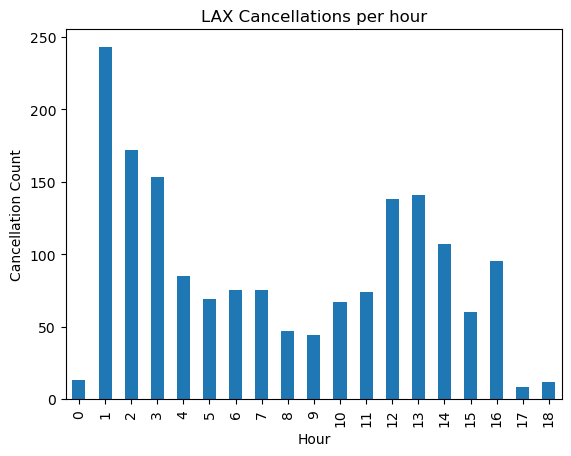

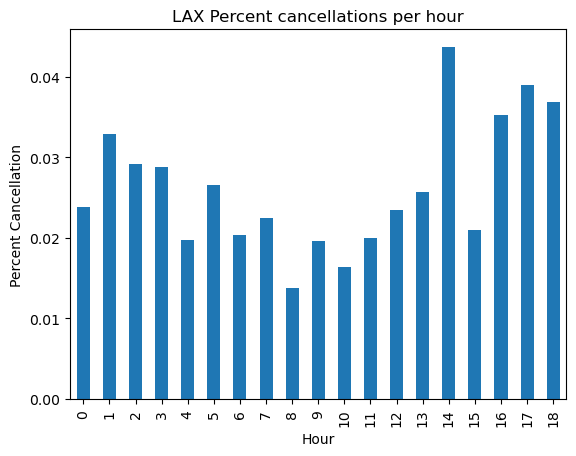

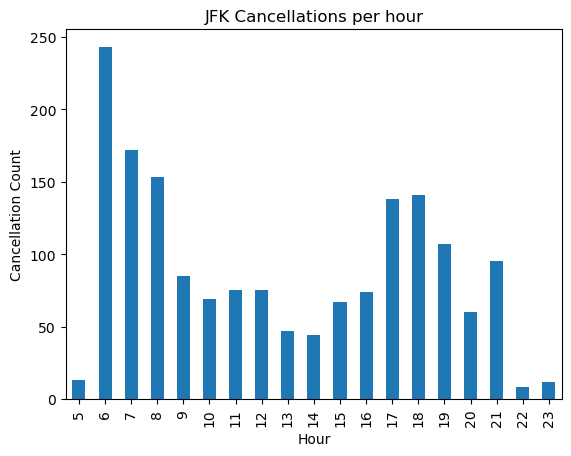

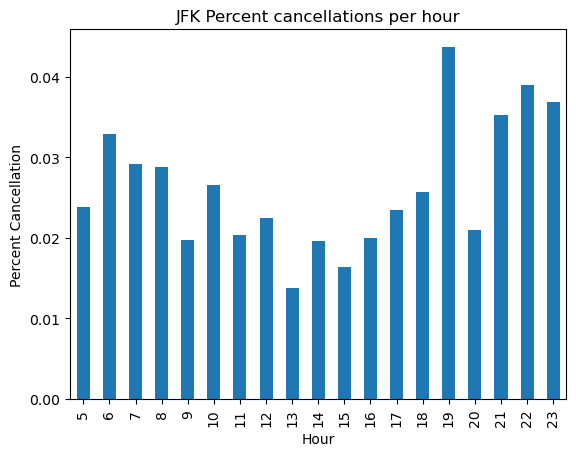

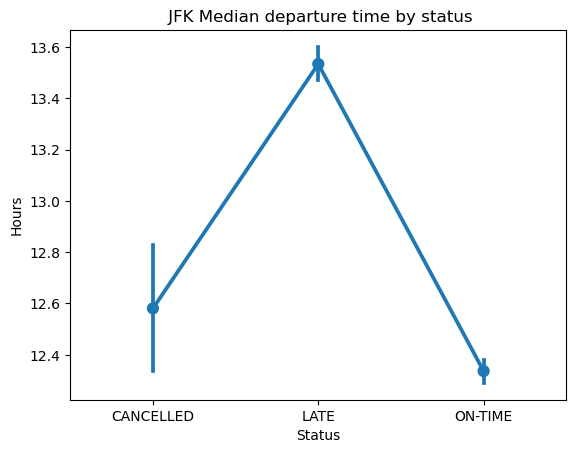

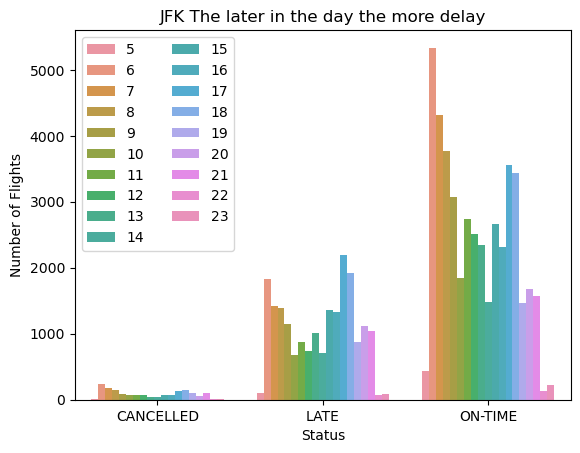

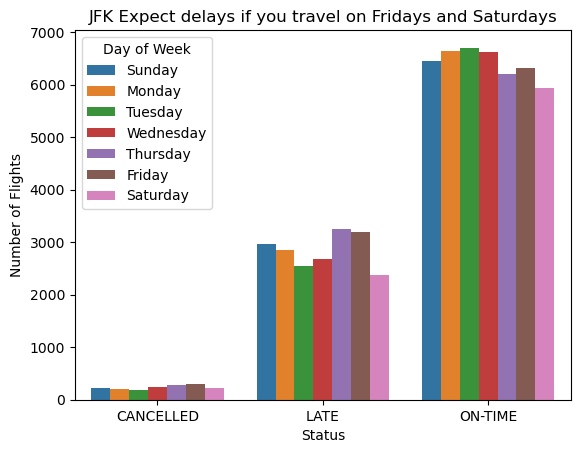

In [93]:
# group flights by status and hour, counting each pair and adding a new column with the counts
WB_STATUS=WB_FLIGHT.groupby(['Status','Hours']).size().reset_index(name='Number of Flights')
WB_TOTAL=WB_FLIGHT.groupby(['Hours']).size().reset_index(name='Number of Flights')
# filter only cancelled flights
WB_CANCELLED=WB_STATUS[WB_STATUS['Status'].isin(['CANCELLED'])]
# create new column with percent cancellations by hour
new_col=[]
for indx,row in WB_CANCELLED.iterrows():
    new_col.append(row['Number of Flights']/WB_TOTAL['Number of Flights'][indx])
WB_TEMP=pd.DataFrame({'percent':new_col})
cols=list(WB_CANCELLED.columns)
cols.append('percent')
WB_CANCELLED=pd.concat([WB_CANCELLED,WB_TEMP],ignore_index=True,axis=1)
WB_CANCELLED.columns=cols
WB_CANCELLED['Number of Flights'].plot.bar()
plt.title("LAX Cancellations per hour")
plt.xlabel("Hour")
plt.ylabel("Cancellation Count")
#plt.xlim(3, 24)  # Setting y-axis limits


plt.show()
WB_CANCELLED['percent'].plot.bar()
plt.title("LAX Percent cancellations per hour")
plt.xlabel("Hour")
plt.ylabel("Percent Cancellation")
#plt.xlim(3, 24)  # Setting y-axis limits
plt.show()

###################################################################################
WB_CANCELLED['Number of Flights'].plot.bar()
plt.title("JFK Cancellations per hour")
plt.xlabel("Hour")
plt.ylabel("Cancellation Count")

# Get the current x-tick labels and add 3 to each
current_xtick_labels = [tick_label + 5 for tick_label in range(len(WB_CANCELLED['Hours']))]

# Set the new x-tick labels
plt.xticks(ticks=range(len(WB_CANCELLED['Hours'])), labels=current_xtick_labels)

plt.show()

# Plot Percent cancellations per hour with updated x-axis labels
WB_CANCELLED['percent'].plot.bar()
plt.title("JFK Percent cancellations per hour")
plt.xlabel("Hour")
plt.ylabel("Percent Cancellation")

# The x-tick labels will be the same as for the previous plot
plt.xticks(ticks=range(len(WB_CANCELLED['Hours'])), labels=current_xtick_labels)

plt.show()

############################################333
# plot means of the three Status categories per hour
sns.pointplot(x='Status',y='Hours',data=WB_FLIGHT).set(title=" JFK Median departure time by status")
plt.show()
# bar graphs for each Status and hour
sns.countplot(x='Status',hue='Hours',data=WB_FLIGHT).set(title="JFK The later in the day the more delay",ylabel="Number of Flights")
plt.legend(loc='upper left',ncol=2)
plt.show()
# bar graphs for each Status and Day of the Week
day_order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
sns.countplot(x='Status',hue='Day of Week',data=WB_FLIGHT,hue_order=day_order).set(title="JFK Expect delays if you travel on Fridays and Saturdays", ylabel="Number of Flights")
plt.show()